### Coursework coding instructions (please also see full coursework spec)

Please choose if you want to do either Task 1 or Task 2. You should write your report about one task only.

For the task you choose you will need to do two approaches:
  - Approach 1, which can use use pre-trained embeddings / models
  - Approach 2, which should not use any pre-trained embeddings or models
We should be able to run both approaches from the same colab file

#### Running your code:
  - Your models should run automatically when running your colab file without further intervention
  - For each task you should automatically output the performance of both models
  - Your code should automatically download any libraries required

#### Structure of your code:
  - You are expected to use the 'train', 'eval' and 'model_performance' functions, although you may edit these as required
  - Otherwise there are no restrictions on what you can do in your code

#### Documentation:
  - You are expected to produce a .README file summarising how you have approached both tasks

#### Reproducibility:
  - Your .README file should explain how to replicate the different experiments mentioned in your report

Good luck! We are really looking forward to seeing your reports and your model code!

In [ ]:
# You will need to download any word embeddings required for your code, e.g.:

# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove.6B.zip

# For any packages that Colab does not provide auotmatically you will also need to install these below, e.g.:

#! pip install torch

In [ ]:
# Imports

import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from torch.utils.data import Dataset, random_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import codecs
import math
import json
import os

In [ ]:
# Setting random seed and device
SEED = 1

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [ ]:
# mount to drive
# from google.colab import drive
# drive.mount('/content/drive/') 
# CWroot = "drive/MyDrive/NLP_CW/"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# Load data
# train_df = pd.read_csv('%sdata/task-1/train.csv'%CWroot)
# test_df = pd.read_csv('%sdata/task-1/dev.csv'%CWroot)

# NOTE: we downloaded the meanGrades for the dev.csv from the competition website, this
# data can be found at <data/task1/dev.csv> in the shared drive link
train_df = pd.read_csv('data/task-1/train.csv')
test_df = pd.read_csv('data/task-1/dev.csv')

In [ ]:
# We define our training loop
def train(train_iter, dev_iter, model, number_epoch):
    """
    Training loop for the model, which calls on eval to evaluate after each epoch
    """

    
    print("Training model.")
    train = {'loss': [], 'RMSE': []}
    valid = {'loss': [], 'RMSE': []}
    for epoch in range(1, number_epoch+1):

        model.train()
        epoch_loss = 0
        epoch_sse = 0
        no_observations = 0  # Observations used for training so far

        for feature, target in train_iter:

            # feature could be a tuple of original and edited sentences
            if not isinstance(feature, tuple):
                feature = (feature,)
            # we only needed the tuple to differentiate data types in collate_fn,
            # could have probably coded this in a better way
            feature = list(feature)
            for i in range(len(feature)):
                feature[i] = feature[i].to(device)
            
            target = target.to(device)

            # for RNN:
            model.batch_size = target.shape[0]
            no_observations = no_observations + target.shape[0]
            if model.mode in ("LSTM", "GRU", "RNN"):
                model.hidden = model.init_hidden()
                if model.concat:
                  model.hidden2 = model.init_hidden()

            predictions = model(*feature).squeeze(1)

            optimizer.zero_grad()

            loss = loss_fn(predictions, target)

            sse, __ = model_performance(predictions.detach().cpu().numpy(), target.detach().cpu().numpy())

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()*target.shape[0]
            epoch_sse += sse

        valid_loss, valid_mse, __, __ = eval(dev_iter, model)
        epoch_loss, epoch_mse = epoch_loss / no_observations, epoch_sse / no_observations

        # store logs
        train['loss'].append(epoch_loss)
        train['RMSE'].append(epoch_mse**0.5)
        valid['loss'].append(valid_loss)
        valid['RMSE'].append(valid_mse**0.5)

        print(f'| Epoch: {epoch:02} | Train Loss: {epoch_loss:.2f} | Train MSE: {epoch_mse:.2f} | Train RMSE: {epoch_mse**0.5:.2f} | \
        Val. Loss: {valid_loss:.2f} | Val. MSE: {valid_mse:.2f} |  Val. RMSE: {valid_mse**0.5:.2f} |')
    
    losses = {'train': train, 'valid': valid}
    return losses

In [ ]:
# We evaluate performance on our dev set
def eval(data_iter, model):
    """
    Evaluating model performance on the dev set
    """
    model.eval()
    epoch_loss = 0
    epoch_sse = 0
    pred_all = []
    trg_all = []
    no_observations = 0

    with torch.no_grad():
        for feature, target in data_iter:

            # feature could be a tuple of original and edited sentences
            if not isinstance(feature, tuple):
                feature = (feature,)

            # we only needed the tuple to differentiate data types in collate_fn,
            # could have probably coded this in a better way
            feature = list(feature)
            for i in range(len(feature)):
                feature[i] = feature[i].to(device)
            
            target = target.to(device)

            # for RNN:
            model.batch_size = target.shape[0]
            no_observations = no_observations + target.shape[0]
            if model.mode in ("LSTM", "GRU", "RNN"):
                model.hidden = model.init_hidden()
                if model.concat:
                  model.hidden2 = model.init_hidden()

            predictions = model(*feature).squeeze(1)
            loss = loss_fn(predictions, target)

            # We get the mse
            pred, trg = predictions.detach().cpu().numpy(), target.detach().cpu().numpy()
            sse, __ = model_performance(pred, trg)

            epoch_loss += loss.item()*target.shape[0]
            epoch_sse += sse
            pred_all.extend(pred)
            trg_all.extend(trg)

    return epoch_loss/no_observations, epoch_sse/no_observations, np.array(pred_all), np.array(trg_all)

In [ ]:
# How we print the model performance
def model_performance(output, target, print_output=False):
    """
    Returns SSE and MSE per batch (printing the MSE and the RMSE)
    """

    sq_error = (output - target)**2

    sse = np.sum(sq_error)
    mse = np.mean(sq_error)
    rmse = np.sqrt(mse)

    if print_output:
        print(f'| MSE: {mse:.2f} | RMSE: {rmse:.2f} |')

    return sse, mse

In [ ]:
import re
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

def create_vocab(df, preprocess=None, remove_stop_words=False, remove_punctuation=False, return_original=False):
    """
    function to parse original and edited sentences, remove stop words and punctuation if needed.

    args:
      - df (DataFrame): pd dataframe containing all data (original sentences, edits, ...)
      - preprocess (callable(s)): custom method to add optional preprocessing to the data. (default = None)
      - remove_stop_words (bool): flag if removing english stop words from the data. (default = False)
      - remove_punctuation (bool): flag if removing punctuation from the data. (default = False)
      - return_original (bool): flag if two return also the original headlines, it will
                                add original words in vocab as needed. (default = False)

    returns:
      - vocab: list of unique tokens in the data (if return_original then original words are
               are added to the vocab as needed).
      - tokenized_corpus_edited: the tokenized edited sentences (without </>).
      - tokenized_corpus_original (optional): the tokenized original sentences. (without </>)
    """

    # 1. replace edited words and remove </> from original sentences
    data_edited = df.apply(lambda x: re.sub(r"<.+/>", x["edit"], x["original"]), axis=1)
    data_original = df["original"].str.replace(r"<(.+)/>", "\g<1>")

    # 2. tokenize original and edited corpora
    tokenized_corpus_edited, tokenized_corpus_original = [], []
    for original, edited in zip(data_original, data_edited):

        # 2.1 preprocess sentence if needed
        if preprocess is not None:
            try:
                if isinstance(preprocess, (tuple, list)):
                    for func in preprocess:
                        original = preprocess(original)
                        edited = preprocess(edited)
                else:
                      original = preprocess(original)
                      edited = preprocess(edited)

            except:
                raise ValueError("WARNING: something went wrong during preprocessing. Use preprocess = None (default) if unsure.")

        # 2.2 remove punctuation if needed
        if remove_punctuation:
            original = re.sub(r'[^\w\s]','',original)
            edited = re.sub(r'[^\w\s]','',edited)

        # 2.3 tokenize sentence
        original = [tok.lower().strip() for tok in original.split(' ') if tok]
        edited = [tok.lower().strip() for tok in edited.split(' ') if tok]

        # 2.4 remove stop words if needed
        if remove_stop_words:
            original = [tok for tok in original if not tok in ENGLISH_STOP_WORDS]
            edited = [tok for tok in edited if not tok in ENGLISH_STOP_WORDS]

        # 2.5 add sentences to the tokenized corpora
        if original:
            tokenized_corpus_original.append(original)
        if edited:
            tokenized_corpus_edited.append(edited)

    # 3. extract vocab from the two corpora and return values
    flattened_edited = [tok for sent in tokenized_corpus_edited for tok in sent]
    vocab = set(flattened_edited)

    if return_original:
      flattened_original = [tok for sent in tokenized_corpus_original for tok in sent]
      vocab.update(flattened_original)
      return vocab, tokenized_corpus_edited, tokenized_corpus_original
    else:
      return vocab, tokenized_corpus_edited

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
def collate_fn_padd(batch):
    '''
    We add padding to our minibatches and create tensors for our model

    MODIFIED: modified so that it can handle multiple input features, namely the
    edited headlines and the original ones. it padds according to the overall maximum
    sentence length.
    '''
    
    features, labels =  zip(*batch)
    if isinstance(features[0], dict):
        features_len = [len(x['x_train']) for x in features]
        features_len_original = [len(x['x_original']) for x in features]
        m1, m2 = max(features_len), max(features_len_original)
        m = max(m1, m2) #overall max sentence length
        seq_tensor = torch.zeros((len(features), m)).long()
        seq_tensor_original = torch.zeros((len(features), m)).long()
        features_len = [(l1,l2) for l1,l2 in zip(features_len, features_len_original)]
    else:
        features_len = [len(x) for x in features]
        seq_tensor = torch.zeros((len(features), max(features_len))).long()
        
    for idx, (seq, seqlen) in enumerate(zip(features, features_len)):
        if isinstance(seq, dict):
          seq_tensor[idx, :seqlen[0]] = torch.LongTensor(seq['x_train'])
          seq_tensor_original[idx, :seqlen[1]] = torch.LongTensor(seq['x_original'])
        else:
          seq_tensor[idx, :seqlen] = torch.LongTensor(seq)

    labels = torch.FloatTensor(labels)
    if isinstance(features[0], dict):
        features = tuple((seq_tensor, seq_tensor_original))
    else:
        features = seq_tensor
        
    return features, labels

class Task1Dataset(Dataset):
    """
    modified the dataset so that it can handle multiple input features, namely the
    edited and original headlines. If both input are queried they will be stored in 
    a dictionary.
    """
    def __init__(self, x_train, y_train, x_original = None):
        self.x_train = x_train
        self.y_train = y_train
        self.x_original = x_original

    def __len__(self):
        return len(self.y_train)

    def __getitem__(self, item):
      if self.x_original is not None: 
        sequences = {'x_train': self.x_train[item], 'x_original': self.x_original[item]}   
        return sequences, self.y_train[item]
      else:
        return self.x_train[item], self.y_train[item]

In [ ]:
class CustomRNN(nn.Module):
    """
    class handle to instanciated a RNN of choice
    """
    def __init__(self, embedding_dim, hidden_dim, vocab_size, num_layers, batch_size, device, mode = "LSTM", bidirectional=True, concat=True):
        """
        inputs:
          -embdedding_dim (int): dimensionality of the embedding layer
          -hidden_dim (int): dimensionality of hidden states
          -vocab_size (int): size of the vocabulary
          -num_layers (int): number of hidden layers
          -batch_size (int): the batch size used by the data loaders
          -device (torch.device): either cuda or cpu device
          -mode (str): what kind of RNN to instanciate. choose from (RNN, GRU, LSTM) default: LSTM
          -bidirectional (bool): if the network should run sequential data in both directions. default = True
          -concat (bool): if we should concatenate the hidden states of the edited and orginal headlines 
        """
        super(CustomRNN, self).__init__()

        self.mode = mode
        self.num_dir = 2 if bidirectional else 1
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        self.num_layers = num_layers
        self.device = device
        self.batch_size = batch_size
        self.concat = concat
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # use nn modules to instanciate the queried model
        if mode == "LSTM":
            self.net = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, bidirectional=bidirectional)
        elif mode =="GRU":
            self.net = nn.GRU(embedding_dim, hidden_dim, num_layers=num_layers, bidirectional=bidirectional)
        elif mode == "RNN":
            self.net = nn.RNN(embedding_dim, hidden_dim, num_layers=num_layers, bidirectional=bidirectional)
        else:
          raise ValueError('unknown mode: %s. accepted modes: (LSTM,GRU,RNN)'%mode)


        # Instanciate the linear layer that maps from hidden state space to tag space.
        # If we are using both original and edited headlines we will concatenate their
        # hidden states. If we are going for bidirectional we will also stack hidden states for
        # different directions.
        n = 2 if concat else 1
        self.hidden2label = nn.Linear(n*hidden_dim*self.num_dir, 1)

        # initialise the hidden layer                             
        self.hidden = self.init_hidden()
        # if we are using two inputs, each both of them will have their hidden state
        if concat:
          self.hidden2 = self.init_hidden()

    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly why they have this dimensionality.
        # The axes semantics are (num_layers * num_directions, minibatch_size, hidden_dim)
        if self.mode == "LSTM":
          return torch.zeros(self.num_dir*self.num_layers, self.batch_size, self.hidden_dim).to(self.device), \
                torch.zeros(self.num_dir*self.num_layers, self.batch_size, self.hidden_dim).to(self.device)
        else:
          return torch.zeros(self.num_dir*self.num_layers, self.batch_size, self.hidden_dim).to(self.device)


    def forward(self, sentence, sentence_original=None):

        #pass input through embedding and reshape to proper format
        embedded = self.embedding(sentence)
        embedded = embedded.permute(1, 0, 2)

        # pass through the recursive model
        out, self.hidden = self.net(embedded.view(len(embedded),
                                                  self.batch_size,
                                                  self.embedding_dim),
                                    self.hidden)
        
        # this block of code handles multiple inputs (if passed)
        if sentence_original is not None:
            # pass original sequence through the embedding layer and reshape to proper format
            embedded2 = self.embedding(sentence_original)
            embedded2 = embedded2.permute(1, 0, 2)

            # pass through recursive model
            out2, self.hidden2 = self.net(embedded2.view(len(embedded2),
                                                  self.batch_size,
                                                  self.embedding_dim),
                                          self.hidden2)

            # concatenate the outputs
            out = torch.cat([out, out2], dim = 2)

        # take last output as the contextual sentence representation
        out = self.hidden2label(out[-1])

        # given that rates are in range (0,3) pass through sigmoid and scale
        out = 3*torch.sigmoid(out)
        return out


class Block(nn.Module):
    """
    Modified transformer encoder block to have the layer normalisation before the 
    residual connection as this was shown to lead to more stable training. Inspired by 
    torch documention, modified appropriately to what we saw in the lectures.
    """
    def __init__(self, embedding_dim, n_heads=1, dropout=0.1, ff_dim = 512):
        super(Block, self).__init__()

        # ==== Multi-head attention block ====
        self.multiHeadAttention = nn.MultiheadAttention(embedding_dim, n_heads,
                                                        dropout=dropout)
                                  
        
        # ==== feed forward block ====
        self.feed_forward = nn.Sequential(nn.Linear(embedding_dim, ff_dim),
                                          nn.ReLU(inplace=True),
                                          nn.Dropout(dropout),
                                          nn.Linear(ff_dim, embedding_dim))

        # === norm layers ===
        self.norm1 = nn.LayerNorm(embedding_dim)
        self.norm2 = nn.LayerNorm(embedding_dim)

        # === additional dropout layers ===
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, sequence):
        # multi-head attention
        out = self.multiHeadAttention(sequence, sequence, sequence)[0]
        
        # layer-norm, dropout and residual connection
        out = sequence + self.dropout1(self.norm1(out))

        # feed forward
        out = self.feed_forward(out)

        # layer-norm, dropout and residual connection
        out = out +self.dropout2(self.norm2(out))

        return out

class PositionalEncoding(nn.Module):
    """
    positional encoding layer to solve permutation equivariance of the attention block,
    inspired by pytorch tutorials on sequence to sequences modelling.
    """
    def __init__(self, embedding_dim, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()

        self.dropout = nn.Dropout(p=dropout)

        # build the positional encoding
        pe = torch.zeros(max_len, embedding_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embedding_dim, 2).float() * (-math.log(10000.0) / embedding_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class CustomTransformerModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim = 300, n_heads=1, ff_dim=256, N=1, dropout=0.1, concat = True):
        super(CustomTransformerModel, self).__init__()

        # ==== handle for train loop (to distinguish between RNN and transformer) ====
        self.mode = "TRANSFORMER"

        # ==== embedding layer ====
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # ==== positional encoding layer ====
        self.positional_encoder = PositionalEncoding(embedding_dim)
        
        # ==== transformer feature extractor ====
        transformer_encoder = []
        for n in range(N):
            transformer_encoder.append(Block(embedding_dim, dropout=dropout, n_heads=n_heads,
                                            ff_dim=ff_dim))
        self.transformer_encoder = nn.Sequential(*transformer_encoder)

        # ==== fully connected regressor for sentiment scoring ====
        # if we are using both original and edited headlines we concatenate their representations
        regressor_features = 2*embedding_dim if concat else embedding_dim
        self.regressor = nn.Sequential(nn.Linear(regressor_features, embedding_dim//2),
                                       nn.ReLU(inplace=True),
                                       nn.Dropout(dropout),
                                       nn.Linear(embedding_dim//2, 1))
        


    def forward(self, sequence, sequence_original = None):
        # pass edited sequence through the embedding layer
        embeddings = self.embedding(sequence)
        # add positional encoding (gets rid of positional equivariance of attention mechanism)
        out = self.positional_encoder(embeddings)
        # pas encoded inputs through the tranformer
        out = self.transformer_encoder(out)

        # this block will handle multiple inputs (if passed)
        if sequence_original is not None:
            # pass original sequence through embedding layer
            embeddings2 = self.embedding(sequence_original)
            # add positional encoding
            out2 = self.positional_encoder(embeddings2)
            # pass encoded input through the transformer
            out2 = self.transformer_encoder(out2)

            # === concatenate both outs and embeddings ===
            
            # instead of taking the mean, we use the attention maps to downsample input embeddings
            # using a weighted sum and pass through a ReLU to add some extra non-linearity
            out = torch.cat([embeddings*out, embeddings2*out2], dim = 2)
            out = F.relu(out).sum(1)
        else:
            out = F.relu(embeddings*out).sum(1)

        # pass output through the regressor
        out = self.regressor(out)
        # again, grades are in range (0,3) so pass through sigmoid and scale
        out = 3*torch.sigmoid(out)
        return out


**APPROACH 1**

In [ ]:
# load GloVe embeddinbgs and choose dimensionality
gloveD = 50

try:
  codecs.open('glove.6B.{}d.txt'.format(gloveD), 'r','utf-8')
except FileNotFoundError:
  !wget http://nlp.stanford.edu/data/glove.6B.zip
  !unzip glove.6B.zip

Attempt to data augmentation

In [ ]:
# === for data augmentation only ===
try:
  import textaugment
except ModuleNotFoundError:
  !pip install textaugment

from textaugment import Wordnet, Translate
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# determine augmentation model
aug_model = Wordnet(v=True, n=True, p=0.5)

# augment training set
def augment(df, model, runs = 2):
    print("starting data augmentation. initial n of samples: {}".format(len(df)))
    for i in range(runs):
        print("[{}]/[{}]augmenting data to double it size...".format(i+1, runs), end="\t")
        # augment original sentences with given model
        originals_aug = df.apply(lambda x: model.augment(x['original']), axis=1)
        df_aug = df.copy(deep=True)
        df_aug['original'] = originals_aug
        # concatenate old data and new data
        df = pd.concat([df, df_aug])
        print("done. new n of samples: {}".format(len(df)))
    return df

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


**LOAD AND PRE-PROCESS DATA**

In [ ]:
from tqdm import tqdm
# === preprocessing corpora and creating vocab ===
def preprocessing(sentence):
    " function handle to remove dashes in-subsequent-words-of-a-sentence"
    return sentence.replace("-", " ")

# uncomment to augment data using the data augmentation funxtion from the previous cell
#train_df = augment(train_df, aug_model)

train_vocab, train_tokenized_corpus_edited, train_tokenized_corpus_original = create_vocab(train_df,
                                                                                           preprocess=preprocessing,
                                                                                           remove_punctuation = True,
                                                                                           remove_stop_words = True,
                                                                                           return_original=True)
test_vocab, test_tokenized_corpus_edited, test_tokenized_corpus_original = create_vocab(test_df,
                                                                                        preprocess=preprocessing,
                                                                                        remove_punctuation = True,
                                                                                        remove_stop_words = True,
                                                                                        return_original=True)
joint_vocab, joint_tokenized_corpus_edited, joint_tokenized_corpus_original = create_vocab(pd.concat([train_df, test_df]),
                                                                                           preprocess=preprocessing,
                                                                                           remove_punctuation = True,
                                                                                           remove_stop_words = True,
                                                                                           return_original=True)
# === loading word embeddings ===
glove_vocab = []
word2idx, word2emb, idx2word, idx2emb = {},{},{},{}
word2idx['<pad>'] = 0
idx2word[0] = '<pad>'
word2emb['<pad>'] = [0]*gloveD
idx2emb[0] = [0]*gloveD
idx, unk_flag =1, True
with codecs.open('glove.6B.{}d.txt'.format(gloveD), 'r','utf-8') as f:
    for line in tqdm(f.readlines(), desc='loading GloVe embeddings...'):
        # Ignore the first line - first line typically contains vocab, dimensionality
        if len(line.strip().split()) > 3:
            word = line.strip().split()[0]
            glove_vocab.append(word)
            if word in joint_vocab:
                emb = list(map(float,line.strip().split()[1:]))
                word2emb[word] = emb
                word2idx[word] = idx
                idx2word[idx] = word
                idx2emb[idx] = emb
                idx+=1
            # extract glove vector for unknown tokens
            elif word == 'unk' and unk_flag:
                unk = list(map(float,line.strip().split()[1:]))
                unk_flag = False

# assign 'unk' to all tokens that were not contained in glove file
out_of_glove_vocab = []
for word in tqdm(joint_vocab, desc='assigning \'unk\' embedding to out of vocab words...'):
    if word not in glove_vocab:
        out_of_glove_vocab.append(word)
        word2emb[word] = unk
        word2idx[word] = idx
        idx2word[idx] = word
        idx2emb[idx] = unk
        idx+=1


print("\nfound %d words in joint_vocab that are not contained in the GloVe file."%len(out_of_glove_vocab))
print("some examples: ", np.random.choice(out_of_glove_vocab, size=(10,)))
print("\nthese words were given the 'unk' embedding from glove")
print("vocabulary size: ", len({key:val for key,val in word2idx.items() if not val=='unk'}))

# handle to convert corpus to its respective indeces
def corpus2idxs(corpus):
  corpus2idx = []
  for sent in corpus:
    sent2idx = []
    for tok in sent:
      sent2idx.append(word2idx[tok])
    corpus2idx.append(sent2idx)
  return corpus2idx

# handle to convert corpus to its respected word embeddings
def corpus2embs(corpus):
  corpus2emb = []
  for sent in corpus:
    sent2emb = []
    for tok in sent:
      sent2emb.append(word2emb[tok])
    corpus2emb.append(sent2emb)
  return corpus2emb

loading GloVe embeddings...: 100%|██████████| 400000/400000 [00:02<00:00, 162097.06it/s]
assigning 'unk' embedding to out of vocab words...: 100%|██████████| 11593/11593 [00:06<00:00, 1844.20it/s]


found 226 words in joint_vocab that are not contained in the GloVe file.
some examples:  ['nonbinary' 'halloweeners' 'grovels' 'emojis' '24473' 'retweeted'
 'strzok' 'weaponizes' 'cyberwars' 'avenatti']

these words were given the 'unk' embedding from glove
vocabulary size:  11594


train statistical ML models (TUNING - will take HOURS, you can directly skip to the next cell with the best models found)

cell hidden for clarity purposes

In [ ]:
HYPERPARAM_TUNING = False # set to true if you wish to verify the tuning experiments (WARNING: takes hours)

In [ ]:
#@title Tuning
# ===== USING GLOVE EMBEDDINGS AND STATISTICAL ML MODELS (USING SKLEARN) =====
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer, r2_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import LinearSVR, SVR
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

if HYPERPARAM_TUNING:
    # === instanciate training and test corpora with their embeddings ===
    # === note that we take the average word vector as a sentence representation ===
    X_train_edited = corpus2embs(train_tokenized_corpus_edited)
    X_train_edited = np.array([np.mean(x, axis=0).tolist() for x in X_train_edited])
    X_train_original = corpus2embs(train_tokenized_corpus_original)
    X_train_original = np.array([np.mean(x, axis=0).tolist() for x in X_train_original])

    X_test_edited = corpus2embs(test_tokenized_corpus_edited)
    X_test_edited = np.array([np.mean(x, axis=0).tolist() for x in X_test_edited])
    X_test_original = corpus2embs(test_tokenized_corpus_original)
    X_test_original = np.array([np.mean(x, axis=0).tolist() for x in X_test_original])

    y_train, y_test = train_labels.to_numpy(), test_labels.to_numpy()

    # === define what inputs to use when training the models ===
    # 1. use only the edited headlines
    # X_train, X_test = X_train_edited, X_test_edited

    # 2. concatenate edited and input sentences
    X_train = np.concatenate((X_train_edited, X_train_original), axis=1)
    X_test = np.concatenate((X_test_edited, X_test_original), axis=1)

    # 3. test ``out of context`` hypothesis by taking euclidean distance between edited
    #    and original embedding representations
    # X_train = X_train_edited - X_train_original
    # X_test =  X_test_edited) - X_test_original

    # === define metrics and useful variables ===
    models = {}
    best_configs = {}
    scores = {'MAE': {}, 'RMSE':{}}
    scoring = {'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
              'RMSE': make_scorer(rmse, greater_is_better=False)}

    def get_metrics(results):
      # get all metrics corr to the outcome with best MAE
      idx = np.argmax(results['mean_test_RMSE'])
      ret = {'MAE': -results['mean_test_MAE'][idx],
            'RMSE': -results['mean_test_RMSE'][idx]}
      return ret

    # === random forest ===
    print('tuning Random Forest...')
    parameters = {'max_depth': [3, 10], 'n_estimators':range(10, 101, 10)}
    model = RandomForestRegressor(random_state=42)
    gridsearch = GridSearchCV(model, parameters, n_jobs=10, verbose = 10, cv=5,
                              scoring=scoring, refit='RMSE')
    gridsearch.fit(X_train, y_train)
    models['Random\nForest'] = gridsearch.best_estimator_
    metrics = get_metrics(gridsearch.cv_results_)
    best_configs['Random\nForest'] = gridsearch.best_params_
    print('best config: {}'.format(gridsearch.best_params_))
    for metric_name, metric in metrics.items():
      scores[metric_name]['Random\nForest'] = metric
      print('{}: {:.4f}'.format(metric_name, metric))

    # === AdaBoost ===
    print('\n\ntuning AdaBoost...')
    parameters = {'base_estimator__max_depth': [3, 10], 'n_estimators':range(10, 101, 10)}
    model = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(random_state=42), random_state=42)
    gridsearch = GridSearchCV(model, parameters, n_jobs=10, verbose = 10, cv=5,
                              scoring=scoring, refit='RMSE')
    gridsearch.fit(X_train, y_train)
    models['AdaBoost'] = gridsearch.best_estimator_
    metrics = get_metrics(gridsearch.cv_results_)
    best_configs['AdaBoost'] = gridsearch.best_params_
    print('best config: {}'.format(gridsearch.best_params_))
    for metric_name, metric in metrics.items():
      scores[metric_name]['AdaBoost'] = metric
      print('{}: {:.4f}'.format(metric_name, metric))

    # === linear regression ===
    print('\n\ntuning Linear Regression...')
    parameters = {}
    model = LinearRegression()
    gridsearch = GridSearchCV(model, parameters, n_jobs=10, verbose = 10, cv=5,
                              scoring=scoring, refit='RMSE')
    gridsearch.fit(X_train, y_train)
    models['Linear\nRegression'] = gridsearch.best_estimator_
    metrics = get_metrics(gridsearch.cv_results_)
    best_configs['Linear\nRegression'] = gridsearch.best_params_
    print('best config: {}'.format(gridsearch.best_params_))
    for metric_name, metric in metrics.items():
      scores[metric_name]['Linear\nRegression'] = metric
      print('{}: {:.4f}'.format(metric_name, metric))

    # === Bayesian Ridge Regression ===
    print('\n\ntuning Bayesian Ridge Regression...')
    parameters = {}
    model = BayesianRidge(normalize=True)
    gridsearch = GridSearchCV(model, parameters, n_jobs=10, verbose = 10, cv=5,
                              scoring=scoring, refit='RMSE')
    gridsearch.fit(X_train, y_train)
    models['Bayesian\nRidge\nRegression'] = gridsearch.best_estimator_
    metrics = get_metrics(gridsearch.cv_results_)
    best_configs['Bayesian\nRidge\nRegression'] = gridsearch.best_params_
    print('best config: {}'.format(gridsearch.best_params_))
    for metric_name, metric in metrics.items():
      scores[metric_name]['Bayesian\nRidge\nRegression'] = metric
      print('{}: {:.4f}'.format(metric_name, metric))

    # === Histogram boosting regressor ===
    print('\n\ntuning Histogram boosting regressor...')
    parameters = {}
    model = HistGradientBoostingRegressor(random_state=42)
    gridsearch = GridSearchCV(model, parameters, n_jobs=10, verbose = 10, cv=5,
                              scoring=scoring, refit='RMSE')
    gridsearch.fit(X_train, y_train)
    models['Histogram\nBoosting\nRegressor'] = gridsearch.best_estimator_
    metrics = get_metrics(gridsearch.cv_results_)
    best_configs['Histogram\nBoosting\nRegressor'] = gridsearch.best_params_
    print('best config: {}'.format(gridsearch.best_params_))
    for metric_name, metric in metrics.items():
      scores[metric_name]['Histogram\nBoosting\nRegressor'] = metric
      print('{}: {:.4f}'.format(metric_name, metric))

    # === kernel support vector regression ===
    print('\n\ntuning Kernel Support Vector Regressor...')
    parameters = {'kernel': ['linear', 'rbf', 'sigmoid'], 'C': [0.1, 1, 2, 3]}
    model = SVR()
    gridsearch = GridSearchCV(model, parameters, n_jobs=10, verbose = 10, cv=5,
                              scoring=scoring, refit='RMSE')
    gridsearch.fit(X_train, y_train)
    models['Kernel\nSupport\nVector\nRegressor'] = gridsearch.best_estimator_
    metrics = get_metrics(gridsearch.cv_results_)
    best_configs['kernel\nSupport\nVector\nRegressor'] = gridsearch.best_params_
    print('best config: {}'.format(gridsearch.best_params_))
    for metric_name, metric in metrics.items():
      scores[metric_name]['Kernel\nSupport\nVector\nRegressor'] = metric
      print('{}: {:.4f}'.format(metric_name, metric), end='\t')

    # # === Gaussian Process ===
    # print('\n\ntuning Gaussian Process...')
    # parameters = {'kernel':[None, # using None sklearn defaults to a Constant*RBF kernel
    #                         Matern()],
    #               'alpha': [10**-n for n in range(5)]}
    # # important to normalize y in a GP regression
    # model = GaussianProcessRegressor(random_state=42, n_restarts_optimizer=5, normalize_y=True) 
    # gridsearch = GridSearchCV(model, parameters, n_jobs=None, verbose = 10, cv=5,
    #                           scoring=scoring, refit='RMSE')
    # gridsearch.fit(X_train, y_train)
    # models['Gaussian\nProcess'] = gridsearch.best_estimator_
    # metrics = get_metrics(gridsearch.cv_results_)
    # best_configs['Gaussian\nProcess'] = gridsearch.best_params_
    # print('best config: {}'.format(gridsearch.best_params_))
    # for metric_name, metric in metrics.items():
    #   scores[metric_name]['Gaussian\nProcess'] = metric
    #   print('{}: {:.4f}'.format(metric_name, metric))

    # === write results to disk ===
    with open('%sresults/Approach1/stacked_sentences/statistical_models_logs.txt'%CWroot, 'w') as fp:
        json.dump(scores, fp)

    with open('%sresults/Approach1/stacked_sentences/statistical_models_best_configs.txt'%CWroot, 'w') as fp:
        json.dump(best_configs, fp)

**Test best statistical ML models found**

fitting Random Forest...	val RMSE: 0.5713 +/- 0.4309
val R2 score 0.0598
fitting AdaBoost...	val RMSE: 0.5802 +/- 0.4609
val R2 score 0.0302
fitting Linear Regression...	val RMSE: 0.5647 +/- 0.4231
val R2 score 0.0815
fitting Bayesian Ridge Regression...	val RMSE: 0.5640 +/- 0.4201
val R2 score 0.0836
fitting Histogram Boosting Regressor...	val RMSE: 0.5682 +/- 0.4353
val R2 score 0.0699
fitting Kernel Support Vector Regressor...	val RMSE: 0.5712 +/- 0.4616
val R2 score 0.0601


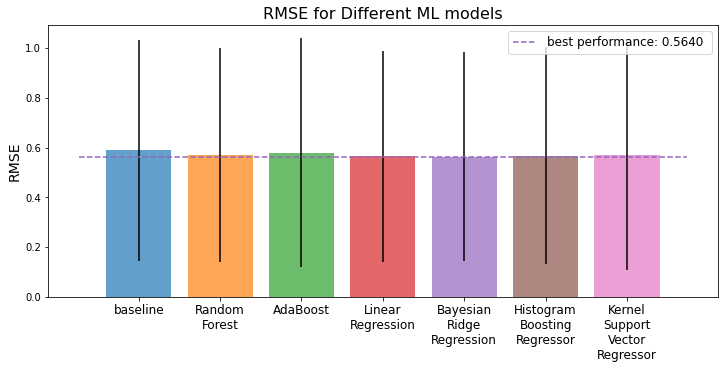



BEST MODEL FOUND WAS:  Bayesian Ridge Regression


In [ ]:
# === instanciate training and test corpora with their embeddings, NOTE: statistical    ===
# === ML models expect input data in matrix form --> input shape: n_sentences*features  ===
# === to this end we use as features the average of the embeddings across each sentence ===
X_edited = corpus2embs(train_tokenized_corpus_edited)
X_edited = np.array([np.mean(x, axis=0).tolist() for x in X_edited]) # take average across sentence
X_original = corpus2embs(train_tokenized_corpus_original)
X_original = np.array([np.mean(x, axis=0).tolist() for x in X_original]) # take average across sentence

X_test_edited = corpus2embs(test_tokenized_corpus_edited)
X_test_edited = np.array([np.mean(x, axis=0).tolist() for x in X_test_edited]) # take average across sentence
X_test_original = corpus2embs(test_tokenized_corpus_original)
X_test_original = np.array([np.mean(x, axis=0).tolist() for x in X_test_original]) # take average across sentence

y, y_test = train_labels.to_numpy(), test_labels.to_numpy()

# === define what inputs to use when training the models ===

# 1. use only the edited headlines
#X, X_test = X_edited, X_test_edited

# 2. concatenate edited and input sentences (best results)
X = np.concatenate((X_edited, X_original), axis=1)
X_test = np.concatenate((X_test_edited, X_test_original), axis=1)

# 3. test ``out of context`` hypothesis by taking euclidean distance between edited
#    and original embedding representations (does not work well)
# X = X_edited - X_original
# X_test =  X_test_edited - X_test_original

# === split train-validation set 90/10 ===
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

# === RE-INSTANCIATE BEST MODELs FOUND ===
models = {'Random\nForest': RandomForestRegressor(random_state=42, max_depth=10, n_estimators=100),
          'AdaBoost': AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=10, random_state=42),
                                        n_estimators=100,
                                        random_state=42),
          'Linear\nRegression': LinearRegression(),
          'Bayesian\nRidge\nRegression': BayesianRidge(),
          'Histogram\nBoosting\nRegressor': HistGradientBoostingRegressor(random_state=42),
          'Kernel\nSupport\nVector\nRegressor': SVR(kernel='rbf', C=1),
          # 'Gaussian\nProcess': GaussianProcessRegressor(random_state=42, n_restarts_optimizer=10,
          #                                               normalize_y=True) # gaussian process did not work well
          }

# === fit models to train set and assess their performance on val set ===
def get_metrics(y_true, y_pred):
    se = (y_true - y_pred)**2
    rmse = float(np.sqrt(np.mean(se)))
    std = float(np.std(se))
    return (rmse, std)

# use the mean of the training set prediction as a baseline model (defined in data analysis section)
results = {'baseline': get_metrics(y_val, np.ones_like(y_val)*baseline)}
for name, model in models.items():
    print('fitting %s...'%name.replace("\n", " "), end="\t")
    model.fit(X_train, y_train)
    pred = model.predict(X_val)
    metrics = get_metrics(pred, y_val)
    print("val RMSE: %.4f +/- %.4f"%(metrics[0], metrics[1]))
    print("val R2 score %.4f"%(r2_score(y_val, pred)))
    results[name] = metrics


# # === write results to disk ===
# with open('%sresults/Approach1/stacked_sentences/results_without_stopwords_and_punct.txt'%CWroot, 'w') as fp:
#     json.dump(results, fp)

# === plot validation results ===
def plot_results(results):
    # === extract results ===
    names, rmses, stds = [], [], []
    for key, res in results.items():
      names.append(key)
      rmses.append(results[key][0])
      stds.append(results[key][1])
    names = np.array(names)
    rmses = np.array(rmses)
    stds = np.array(stds)

    # === plot results ===
    fig = plt.figure(figsize = (12,5))
    ax = fig.add_subplot(111)
    x = np.arange(len(results))
    colors = np.array([next(ax._get_lines.prop_cycler)['color'] for _ in results])
    ax.bar(x, rmses, yerr=stds, color=colors, alpha=0.7)
    ax.plot(ax.get_xlim(), [min(rmses)]*2, c=colors[rmses == min(rmses)].item(),
            ls='--', label="best performance: {:.4f} ".format(min(rmses)))

    plt.xticks(x, names, fontsize=12)
    plt.ylabel('RMSE', fontsize=14)
    plt.title("RMSE for Different ML models", fontsize=16)
    plt.legend(fontsize=12)
    plt.show()

    # === also return the best model ===
    best_model_name = names[rmses == min(rmses)].item()
    best_model = models[best_model_name]
    print("\n\nBEST MODEL FOUND WAS: ", best_model_name.replace("\n", " "))
    return best_model

best_model = plot_results(results)

**INSPECT BEST MODEL OUTPUT DISTRIBUTION**

test RMSE:  0.557569907596281
test r2 score:  0.07072736112226374


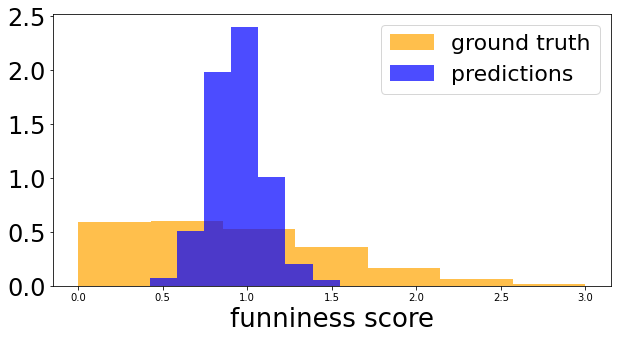

In [ ]:
# refit best model on all data
best_model.fit(X, y)
pred = best_model.predict(X_test)
print("test RMSE: ", float(np.sqrt(np.mean((y_test - pred)**2))))
print("test r2 score: ", r2_score(y_test, pred))
fig = plt.figure(figsize=(10, 5))
plt.hist(y_test, color='orange', alpha=0.7, bins=7, label="ground truth", density=True)
plt.hist(pred, color='b', alpha=0.7, bins=7, label="predictions", density=True)
plt.yticks(fontsize=24)
plt.xlabel('funniness score', fontsize=26)
plt.legend(fontsize=22)
# plt.savefig('%sresults/Approach1/BayesianRidgreOutDistr.pdf'%CWroot)
plt.show()

**LOADS FILES FROM DRIVE AND CREATES FIGURE FOR THE REPORT**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


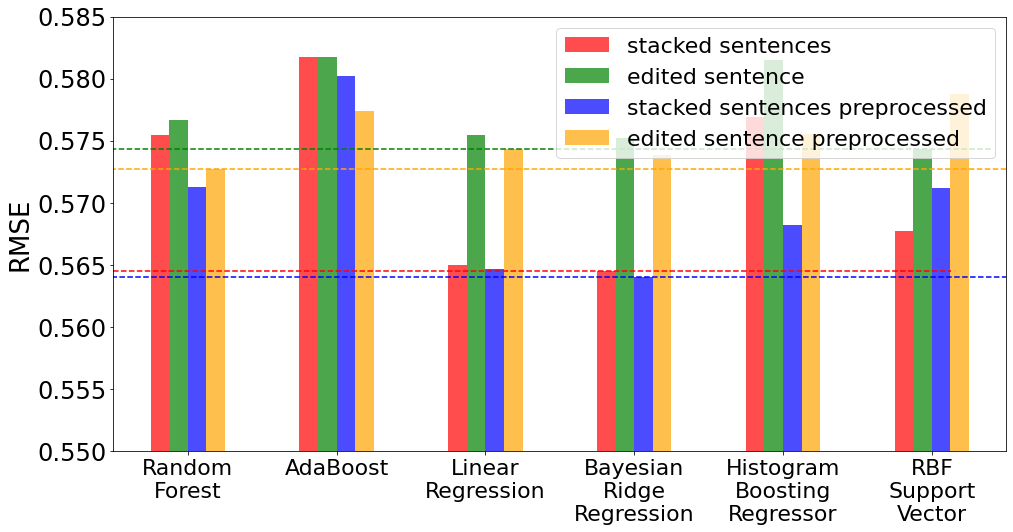

In [ ]:
# # === create plot to display validation results in report ===
# with open('%sresults/Approach1/stacked_sentences/results_without_stopwords_and_punct.txt'%CWroot, 'r') as fp:
#     stacked_preprocessed = json.load(fp)

# with open('%sresults/Approach1/stacked_sentences/results_with_stopwords_and_punct.txt'%CWroot, 'r') as fp:
#     stacked = json.load(fp)

# with open('%sresults/Approach1/single_sentence/results_without_stopwords_and_punct.txt'%CWroot, 'r') as fp:
#     single_preprocessed = json.load(fp)

# with open('%sresults/Approach1/single_sentence/results_with_stopwords_and_punct.txt'%CWroot, 'r') as fp:
#     single = json.load(fp)

# results = {"stacked sentences": stacked,
#            "edited sentence": single,
#            "stacked sentences preprocessed": stacked_preprocessed,
#            "edited sentence preprocessed": single_preprocessed}

# fig = plt.figure(figsize=(16, 8))
# colors = ['r', 'g', 'b', 'orange']
# x = np.arange(len(stacked)-1)
# width = 1/8
# for idx, (outer_names, outer_results) in enumerate(results.items()):
#     names, rmses, stds = [], [], []
#     for key, res in outer_results.items():
#       if key == "baseline":
#         continue
#       elif key == "Kernel\nSupport\nVector\nRegressor":
#         key = "RBF\nSupport\nVector"
#       names.append(key)
#       rmses.append(res[0])
#       stds.append(res[1])

#     ax = fig.add_subplot(111)
#     x_i = x + (idx - 1.5) * width
#     ax.bar(x_i, rmses, color=colors[idx], width=width, alpha=0.7, label = outer_names)
#     ax.plot(ax.get_xlim(), [min(rmses)]*2, c=colors[idx],
#             ls='--')

# plt.xticks(x, names, fontsize=22)
# plt.yticks(fontsize=24)
# plt.ylim([0.55, 0.585])
# plt.xlim([-.5, 5.5])
# plt.ylabel('RMSE', fontsize=26)
# plt.legend(fontsize=22)
# # plt.savefig('%sresults/Approach1/statisticalMLmodels.pdf'%CWroot)
# plt.show()

**DEEP LEARNING MODELS USING PRE-TRAINED GLOVE EMBEDDINGS**

Dataloaders created.
RNN_BiDir model initialised. n tunable parameters: 977
Training model.
| Epoch: 01 | Train Loss: 0.71 | Train MSE: 0.71 | Train RMSE: 0.84 |         Val. Loss: 0.54 | Val. MSE: 0.54 |  Val. RMSE: 0.74 |
| Epoch: 02 | Train Loss: 0.47 | Train MSE: 0.47 | Train RMSE: 0.68 |         Val. Loss: 0.39 | Val. MSE: 0.39 |  Val. RMSE: 0.63 |
| Epoch: 03 | Train Loss: 0.38 | Train MSE: 0.38 | Train RMSE: 0.62 |         Val. Loss: 0.36 | Val. MSE: 0.36 |  Val. RMSE: 0.60 |
| Epoch: 04 | Train Loss: 0.36 | Train MSE: 0.36 | Train RMSE: 0.60 |         Val. Loss: 0.35 | Val. MSE: 0.35 |  Val. RMSE: 0.59 |
| Epoch: 05 | Train Loss: 0.35 | Train MSE: 0.35 | Train RMSE: 0.60 |         Val. Loss: 0.35 | Val. MSE: 0.35 |  Val. RMSE: 0.59 |
| Epoch: 06 | Train Loss: 0.35 | Train MSE: 0.35 | Train RMSE: 0.59 |         Val. Loss: 0.35 | Val. MSE: 0.35 |  Val. RMSE: 0.59 |
| Epoch: 07 | Train Loss: 0.35 | Train MSE: 0.35 | Train RMSE: 0.59 |         Val. Loss: 0.35 | Val. MSE: 0.35 |  Va

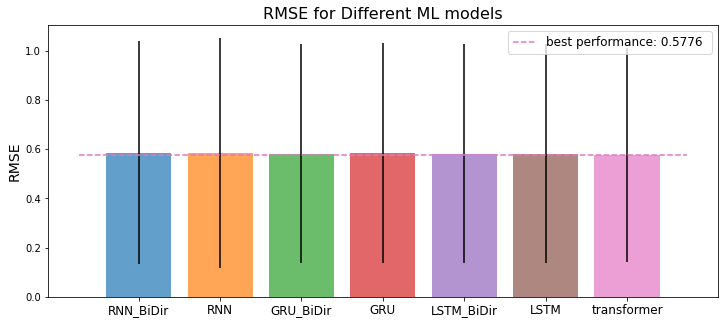



BEST MODEL FOUND WAS:  transformer


In [ ]:
# # ===== USING GLOVE EMBEDDINGS AND DL MODELS (USING TORCH) =====

# === create input sequences from their ids, for the edited and original sentences ===
# === note that now we are using each word embedding as input (power of these architectures) ===

# edited
X_edited = corpus2idxs(train_tokenized_corpus_edited)
X_test_edited = corpus2idxs(test_tokenized_corpus_edited)

# original
X_original = corpus2idxs(train_tokenized_corpus_original)
X_test_original = corpus2idxs(test_tokenized_corpus_original)

# mean grades
y, y_test = train_labels.to_numpy(), test_labels.to_numpy()

# === instanciate data loader using edited and/or original sentences ===
CONCAT = False # IMPORTANT: change to False if modifying below datasets
train_and_dev = Task1Dataset(X_edited, y)#, X_original) # best results without both headlines
test = Task1Dataset(X_test_edited, y_test)#, X_test_original) # best results without both headlines

train_proportion = 0.9
train_examples = round(len(train_and_dev)*train_proportion)
dev_examples = len(train_and_dev) - train_examples

train_dataset, dev_dataset = random_split(train_and_dev,
                                           (train_examples,
                                            dev_examples))

BATCH_SIZE = 64
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)
dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)
test_loader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)

print("Dataloaders created.")

def get_metrics(y_true, y_pred):
    se = (y_true - y_pred)**2
    rmse = float(np.sqrt(np.mean(se)))
    std = float(np.std(se))
    return (rmse, std)

# ===== instanciate hyper-params and variables for the models =====
epochs = 20
VOCAB_SIZE = len(idx2emb)
EMBEDDING_DIM = gloveD
N_HEADS = 1
N_LAYERS = 1
DROPOUT = 0.5
HIDDEN_FF_DIM = 8

loss_fn = nn.MSELoss()
loss_fn = loss_fn.to(device)

# # ===== LAUNCH EXPERIMENTS =====
logs, results, models = {}, {}, {}
# ===== rnns =====
config = ["RNN", "GRU", "LSTM"]
for mode in config:
    for bidir in [True, False]:
        name = mode
        if bidir:
            name+="_BiDir"
        model = CustomRNN(EMBEDDING_DIM, HIDDEN_FF_DIM, VOCAB_SIZE, N_LAYERS,
                          BATCH_SIZE, device, mode=mode, bidirectional=bidir, concat=CONCAT)
        
        # == load glove embeddings ==
        model.embedding.from_pretrained(torch.tensor(list(idx2emb.values())), padding_idx=0)
        model.embedding.weight.requires_grad = False # freeze embedding weights

        # ==set up model and train
        n_params = sum([np.prod(p.shape) for _,p in model.named_parameters() if p.requires_grad])
        print("{} model initialised. n tunable parameters: {}".format(name, n_params))
        model.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.0002)
        losses = train(train_loader, dev_loader, model, epochs)
        logs[name] = losses

        # == test model on devset ==
        _, _, pred, y_true = eval(dev_loader, model)
        metrics = get_metrics(pred, y_true)
        print("final val RMSE: %.4f +/- %.4f"%(metrics[0], metrics[1]))
        results[name] = metrics
        models[name] = model


# ===== transformer =====  
model = CustomTransformerModel(VOCAB_SIZE, EMBEDDING_DIM, N_HEADS, HIDDEN_FF_DIM, N_LAYERS, DROPOUT, CONCAT)

# == load glove embeddings ==
model.embedding.from_pretrained(torch.tensor(list(idx2emb.values())), padding_idx=0)
model.embedding.weight.requires_grad = False # freeze embedding weights

# ==set up model and train
n_params = sum([np.prod(p.shape) for _,p in model.named_parameters() if p.requires_grad])
print("transformer model initialised. n tunable parameters: {}".format(n_params))
model.to(device)
optimizer = torch.optim.Adam(model.parameters())
losses = train(train_loader, dev_loader, model, epochs)
logs["transformer"] = losses

# == test model ==
_, _, pred, y_true = eval(dev_loader, model)
metrics = get_metrics(pred, y_true)
print("final val RMSE: %.4f +/- %.4f"%(metrics[0], metrics[1]))
results["transformer"] = metrics
models["transformer"] = model

# # === write results to disk ===
# with open('%sresults/Approach2/single_sentence/results_without_stopwords_and_punct.txt'%CWroot, 'w') as fp:
#     json.dump(results, fp)

# === plot results ===
best_model = plot_results(results)

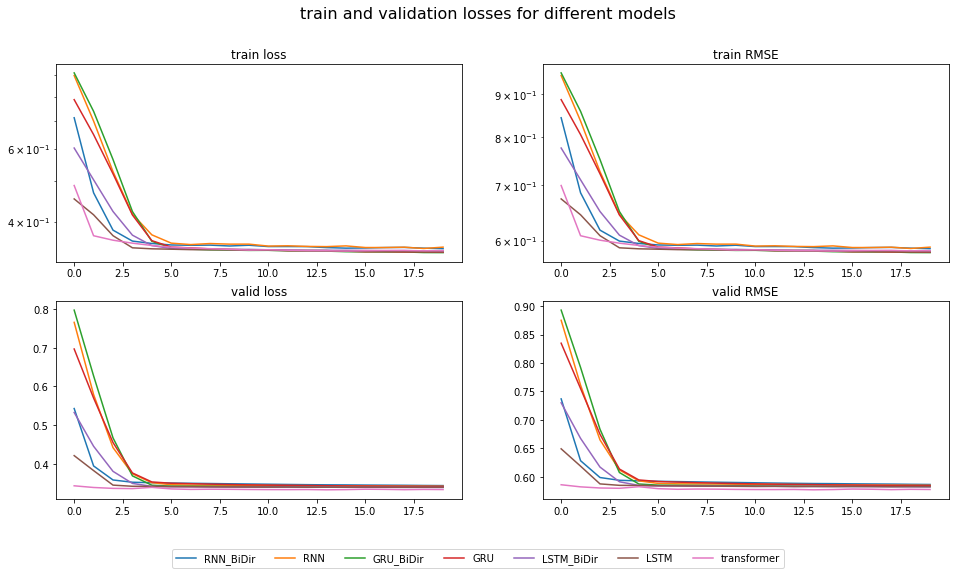

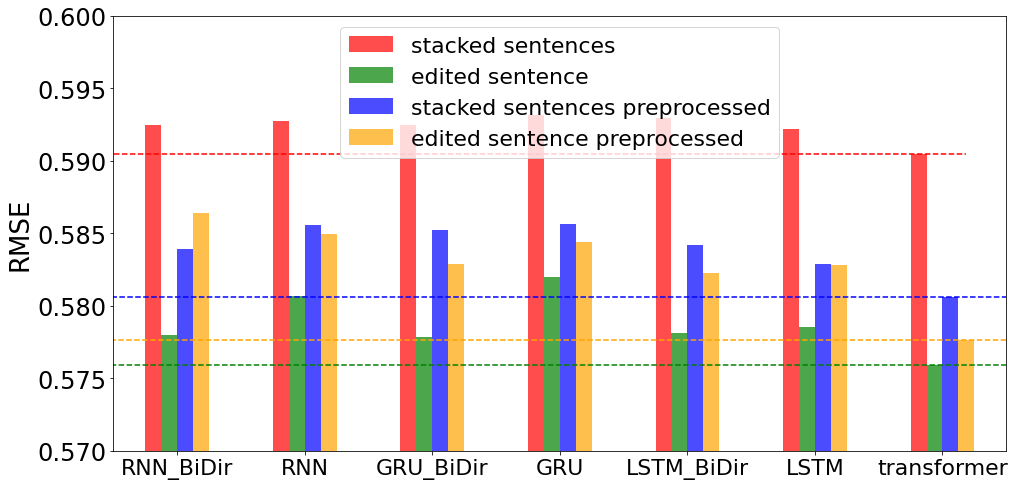

In [ ]:
# ===== plot training logs ====
fig, axs = plt.subplots(2,2, figsize=(16,8))
for model, log in logs.items():
  for i, (trainval, losses) in enumerate(log.items()):
    for j, (name, loss) in enumerate(losses.items()):
      color = next(axs[i,j]._get_lines.prop_cycler)['color']
      axs[i,j].plot(loss, c=color, label=model)
      axs[i,j].set_title("%s %s"%(trainval, name))
      axs[0,j].set_yscale("log")
handles, labels = axs[0,0].get_legend_handles_labels()
fig.suptitle("train and validation losses for different models", fontsize=16)
fig.legend(handles, labels, ncol = len(logs), loc='lower center')

# CODE BELOW LOADS FILES FROM DRIVE AND CREATES IMAGE FOR REPORT

# # === create plot to display in report ===
# with open('%sresults/Approach2/stacked_sentences/results_without_stopwords_and_punct.txt'%CWroot, 'r') as fp:
#     stacked_preprocessed = json.load(fp)

# with open('%sresults/Approach2/stacked_sentences/results_with_stopwords_and_punct.txt'%CWroot, 'r') as fp:
#     stacked = json.load(fp)

# with open('%sresults/Approach2/single_sentence/results_without_stopwords_and_punct.txt'%CWroot, 'r') as fp:
#     single_preprocessed = json.load(fp)

# with open('%sresults/Approach2/single_sentence/results_with_stopwords_and_punct.txt'%CWroot, 'r') as fp:
#     single = json.load(fp)

# results = {"stacked sentences": stacked,
#            "edited sentence": single,
#            "stacked sentences preprocessed": stacked_preprocessed,
#            "edited sentence preprocessed": single_preprocessed}

# fig = plt.figure(figsize=(16, 8))
# ax = fig.add_subplot(111)
# colors = ['r', 'g', 'b', 'orange']
# x = np.arange(len(stacked))
# width = 1/8
# for idx, (outer_names, outer_results) in enumerate(results.items()):
#     names, rmses, stds = [], [], []
#     for key, res in outer_results.items():
#       names.append(key)
#       rmses.append(res[0])
#       stds.append(res[1])
    
#     x_i = x + (idx - 1.5) * width
#     ax.bar(x_i, rmses, color=colors[idx], width=width, alpha=0.7, label = outer_names)
#     ax.plot(ax.get_xlim(), [min(rmses)]*2, c=colors[idx],
#             ls='--')

# plt.xticks(x, names, fontsize=22)
# plt.yticks(fontsize=24)
# plt.ylim([0.57, 0.6])
# plt.xlim([-.5, 6.5])
# plt.ylabel('RMSE', fontsize=26)
# plt.legend(fontsize=22)
# # plt.savefig('%sresults/Approach1/DLmodels.pdf'%CWroot)
# plt.show()

**INSPECT BEST MODEL OUTPUT DISTRIBUTION**

Dataloaders created.
Training model.
| Epoch: 01 | Train Loss: 0.55 | Train MSE: 0.55 | Train RMSE: 0.74 |         Val. Loss: 0.35 | Val. MSE: 0.35 |  Val. RMSE: 0.59 |
| Epoch: 02 | Train Loss: 0.38 | Train MSE: 0.38 | Train RMSE: 0.61 |         Val. Loss: 0.35 | Val. MSE: 0.35 |  Val. RMSE: 0.59 |
| Epoch: 03 | Train Loss: 0.36 | Train MSE: 0.36 | Train RMSE: 0.60 |         Val. Loss: 0.35 | Val. MSE: 0.35 |  Val. RMSE: 0.59 |
| Epoch: 04 | Train Loss: 0.35 | Train MSE: 0.35 | Train RMSE: 0.60 |         Val. Loss: 0.34 | Val. MSE: 0.34 |  Val. RMSE: 0.58 |
| Epoch: 05 | Train Loss: 0.35 | Train MSE: 0.35 | Train RMSE: 0.59 |         Val. Loss: 0.34 | Val. MSE: 0.34 |  Val. RMSE: 0.58 |
| Epoch: 06 | Train Loss: 0.35 | Train MSE: 0.35 | Train RMSE: 0.59 |         Val. Loss: 0.34 | Val. MSE: 0.34 |  Val. RMSE: 0.58 |
| Epoch: 07 | Train Loss: 0.35 | Train MSE: 0.35 | Train RMSE: 0.59 |         Val. Loss: 0.34 | Val. MSE: 0.34 |  Val. RMSE: 0.58 |
| Epoch: 08 | Train Loss: 0.35 | Train 

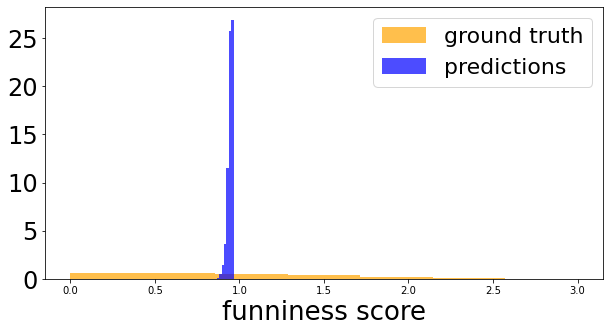

In [ ]:
# === instanciate data loader using edited and/or original sentences ===
CONCAT = False # IMPORTANT: change to False if modifying below datasets
train_set = Task1Dataset(X_edited, y)#, X_original) # best results without both headlines
test = Task1Dataset(X_test_edited, y_test)#, X_test_original) # best results without both headlines

BATCH_SIZE = 64
train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)
test_loader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)
print("Dataloaders created.")

# ==train best model on full train set ===
best_model = CustomTransformerModel(VOCAB_SIZE, EMBEDDING_DIM, N_HEADS, HIDDEN_FF_DIM, N_LAYERS, DROPOUT, CONCAT)
# == load glove embeddings ==
best_model.embedding.from_pretrained(torch.tensor(list(idx2emb.values())), padding_idx=0)
best_model.embedding.weight.requires_grad = False # freeze embedding weights
best_model.to(device)

optimizer = torch.optim.Adam(best_model.parameters())
losses = train(train_loader, test_loader, best_model, epochs)

# == test model ==
_, _, pred, y_true = eval(test_loader, best_model)
print("test RMSE: ", float(np.sqrt(np.mean((y_true - pred)**2))))
print("test r2 score: ", r2_score(y_true, pred))
fig = plt.figure(figsize=(10, 5))
plt.hist(y_test, color='orange', alpha=0.7, bins=7, label="ground truth", density=True)
plt.hist(pred, color='b', alpha=0.7, bins=7, label="predictions", density=True)
plt.yticks(fontsize=24)
plt.xlabel('funniness score', fontsize=26)
plt.legend(fontsize=22)
plt.show()

APPROACH 2 (NO PRETRAINED MODELS OR EMBEDDINGS)

Dataloaders created.
RNN_BiDir model initialised. n tunable parameters: 92873
Training model.
| Epoch: 01 | Train Loss: 0.51 | Train MSE: 0.51 | Train RMSE: 0.72 |         Val. Loss: 0.43 | Val. MSE: 0.43 |  Val. RMSE: 0.66 |
| Epoch: 02 | Train Loss: 0.42 | Train MSE: 0.42 | Train RMSE: 0.65 |         Val. Loss: 0.37 | Val. MSE: 0.37 |  Val. RMSE: 0.61 |
| Epoch: 03 | Train Loss: 0.37 | Train MSE: 0.37 | Train RMSE: 0.61 |         Val. Loss: 0.34 | Val. MSE: 0.34 |  Val. RMSE: 0.58 |
| Epoch: 04 | Train Loss: 0.35 | Train MSE: 0.35 | Train RMSE: 0.59 |         Val. Loss: 0.33 | Val. MSE: 0.33 |  Val. RMSE: 0.57 |
| Epoch: 05 | Train Loss: 0.35 | Train MSE: 0.35 | Train RMSE: 0.59 |         Val. Loss: 0.33 | Val. MSE: 0.33 |  Val. RMSE: 0.57 |
| Epoch: 06 | Train Loss: 0.34 | Train MSE: 0.34 | Train RMSE: 0.59 |         Val. Loss: 0.32 | Val. MSE: 0.32 |  Val. RMSE: 0.57 |
| Epoch: 07 | Train Loss: 0.34 | Train MSE: 0.34 | Train RMSE: 0.59 |         Val. Loss: 0.32 | Val. MSE: 0.32 |  

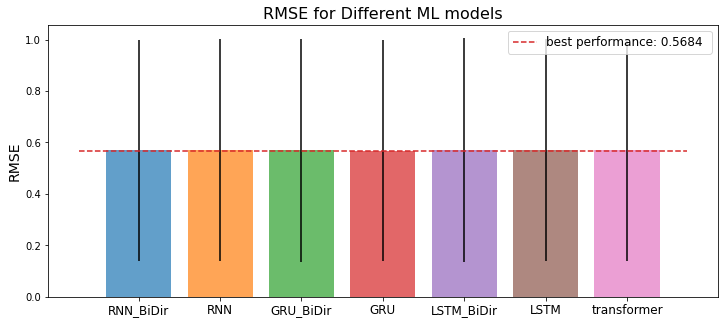



BEST MODEL FOUND WAS:  GRU


In [ ]:
# ===== USING DL MODELS (USING TORCH) =====
# === create input sequences from their ids, for the edited and original sentences ===
# === note that now we are using each word embedding as input (power of these architectures) ===

# edited
X_edited = corpus2idxs(train_tokenized_corpus_edited)
X_test_edited = corpus2idxs(test_tokenized_corpus_edited)

# original
X_original = corpus2idxs(train_tokenized_corpus_original)
X_test_original = corpus2idxs(test_tokenized_corpus_original)

# mean grades
y, y_test = train_labels.to_numpy(), test_labels.to_numpy()

# === instanciate data loader using edited and/or original sentences ===
CONCAT = False
train_and_dev = Task1Dataset(X_edited, y)#, X_original)
test = Task1Dataset(X_test_edited, y_test)#, X_test_original)

train_proportion = 0.9
train_examples = round(len(train_and_dev)*train_proportion)
dev_examples = len(train_and_dev) - train_examples

train_dataset, dev_dataset = random_split(train_and_dev,
                                           (train_examples,
                                            dev_examples))

BATCH_SIZE = 64
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)
dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)
test_loader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)

print("Dataloaders created.")

def get_metrics(y_true, y_pred):
    se = (y_true - y_pred)**2
    rmse = float(np.sqrt(np.mean(se)))
    std = float(np.std(se))
    return (rmse, std)

# ===== instanciate hyper-params and variables for the models =====
epochs = 20
VOCAB_SIZE = len(idx2emb)
EMBEDDING_DIM = 8 # significantly reduced embedding size, few training data.
N_HEADS = 1
N_LAYERS = 1
DROPOUT = 0.5
HIDDEN_FF_DIM = 4

loss_fn = nn.MSELoss()
loss_fn = loss_fn.to(device)

# # ===== LAUNCH EXPERIMENTS =====
logs, results, models = {}, {}, {}
# ===== rnns =====
config = ["RNN", "GRU", "LSTM"]
for mode in config:
    for bidir in [True, False]:
        name = mode
        if bidir:
            name+="_BiDir"
        model = CustomRNN(EMBEDDING_DIM, HIDDEN_FF_DIM, VOCAB_SIZE, N_LAYERS,
                          BATCH_SIZE, device, mode=mode, bidirectional=bidir, concat=CONCAT)
        
        # ==set up model and train
        n_params = sum([np.prod(p.shape) for _,p in model.named_parameters() if p.requires_grad])
        print("{} model initialised. n tunable parameters: {}".format(name, n_params))
        model.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.0002)
        losses = train(train_loader, dev_loader, model, epochs)
        logs[name] = losses
      
        # == test model ==
        _, _, pred, y_true = eval(dev_loader, model)
        metrics = get_metrics(pred, y_true)
        print("test RMSE: %.4f +/- %.4f"%(metrics[0], metrics[1]))
        results[name] = metrics
        models[name] = model

# ===== transformer =====  
model = CustomTransformerModel(VOCAB_SIZE, EMBEDDING_DIM, N_HEADS, HIDDEN_FF_DIM, N_LAYERS, DROPOUT, CONCAT)

# ==set up model and train
n_params = sum([np.prod(p.shape) for _,p in model.named_parameters() if p.requires_grad])
print("transformer model initialised. n tunable parameters: {}".format(n_params))
model.to(device)
optimizer = torch.optim.Adam(model.parameters())
losses = train(train_loader, dev_loader, model, epochs)
logs["transformer"] = losses

# == test model ==
_, _, pred, y_true = eval(dev_loader, model)
metrics = get_metrics(pred, y_true)
print("test RMSE: %.4f +/- %.4f"%(metrics[0], metrics[1]))
results["transformer"] = metrics
models["transformer"] = model

# # === write results to disk ===
# with open('%sresults/Approach2/no_embeddings/single_sentence/results_without_stopwords_and_punct.txt'%CWroot, 'w') as fp:
#     json.dump(results, fp)

# === plot results ===
best_model = plot_results(results)

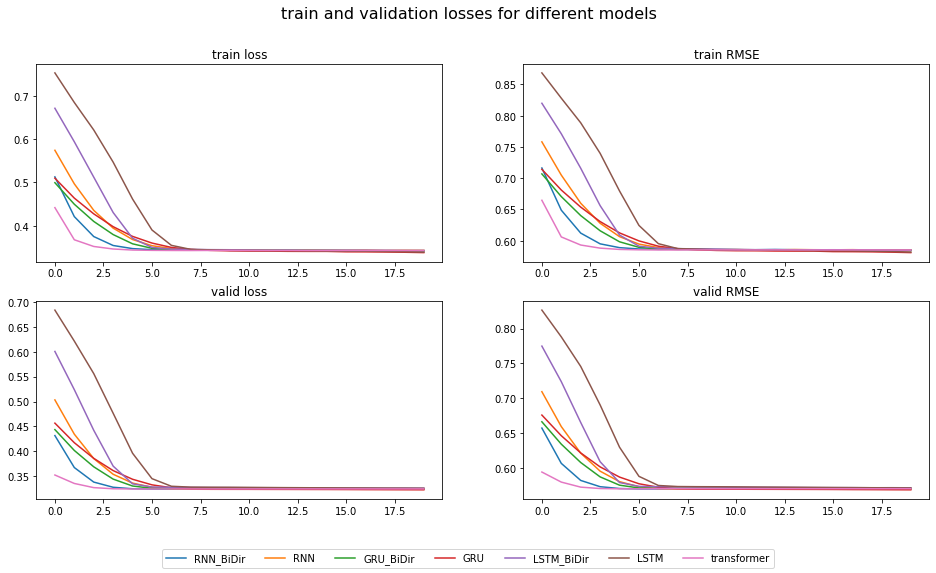

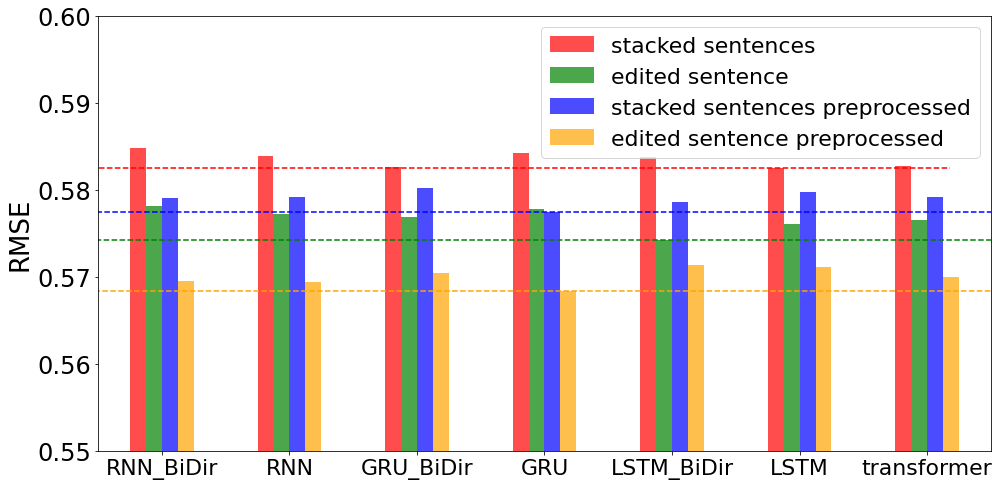

In [ ]:
# ===== plot training logs ====
fig, axs = plt.subplots(2,2, figsize=(16,8))
for model, log in logs.items():
  for i, (trainval, losses) in enumerate(log.items()):
    for j, (name, loss) in enumerate(losses.items()):
      color = next(axs[i,j]._get_lines.prop_cycler)['color']
      axs[i,j].plot(loss, c=color, label=model)
      axs[i,j].set_title("%s %s"%(trainval, name))

handles, labels = axs[0,0].get_legend_handles_labels()
fig.suptitle("train and validation losses for different models", fontsize=16)
fig.legend(handles, labels, ncol = len(logs), loc='lower center')

# CODE BELOW CREATES PLOT FOR REPORT

# # === create plot to display in report ===
# with open('%sresults/Approach2/no_embeddings/stacked_sentences/results_without_stopwords_and_punct.txt'%CWroot, 'r') as fp:
#     stacked_preprocessed = json.load(fp)

# with open('%sresults/Approach2/no_embeddings/stacked_sentences/results_with_stopwords_and_punct.txt'%CWroot, 'r') as fp:
#     stacked = json.load(fp)

# with open('%sresults/Approach2/no_embeddings/single_sentence/results_without_stopwords_and_punct.txt'%CWroot, 'r') as fp:
#     single_preprocessed = json.load(fp)

# with open('%sresults/Approach2/no_embeddings/single_sentence/results_with_stopwords_and_punct.txt'%CWroot, 'r') as fp:
#     single = json.load(fp)

# results = {"stacked sentences": stacked,
#            "edited sentence": single,
#            "stacked sentences preprocessed": stacked_preprocessed,
#            "edited sentence preprocessed": single_preprocessed}

# fig = plt.figure(figsize=(16, 8))
# ax = fig.add_subplot(111)
# colors = ['r', 'g', 'b', 'orange']
# x = np.arange(len(stacked))
# width = 1/8
# for idx, (outer_names, outer_results) in enumerate(results.items()):
#     names, rmses, stds = [], [], []
#     for key, res in outer_results.items():
#       names.append(key)
#       rmses.append(res[0])
#       stds.append(res[1])

#     x_i = x + (idx - 1.5) * width
#     ax.bar(x_i, rmses, color=colors[idx], width=width, alpha=0.7, label = outer_names)
#     ax.plot(ax.get_xlim(), [min(rmses)]*2, c=colors[idx],
#             ls='--')

# plt.xticks(x, names, fontsize=22)
# plt.yticks(fontsize=24)
# plt.ylim([0.55, 0.6])
# plt.xlim([-.5, 6.5])
# plt.ylabel('RMSE', fontsize=26)
# plt.legend(fontsize=22)
# # plt.savefig('%sresults/Approach2/DLmodels_no_embeddings.pdf'%CWroot)
# plt.show()

TEST BEST MODEL ON TEST SET

Dataloaders created.
Training model.
| Epoch: 01 | Train Loss: 0.67 | Train MSE: 0.67 | Train RMSE: 0.82 |         Val. Loss: 0.51 | Val. MSE: 0.51 |  Val. RMSE: 0.71 |
| Epoch: 02 | Train Loss: 0.54 | Train MSE: 0.54 | Train RMSE: 0.73 |         Val. Loss: 0.43 | Val. MSE: 0.43 |  Val. RMSE: 0.65 |
| Epoch: 03 | Train Loss: 0.45 | Train MSE: 0.45 | Train RMSE: 0.67 |         Val. Loss: 0.39 | Val. MSE: 0.39 |  Val. RMSE: 0.62 |
| Epoch: 04 | Train Loss: 0.40 | Train MSE: 0.40 | Train RMSE: 0.64 |         Val. Loss: 0.35 | Val. MSE: 0.35 |  Val. RMSE: 0.59 |
| Epoch: 05 | Train Loss: 0.38 | Train MSE: 0.38 | Train RMSE: 0.62 |         Val. Loss: 0.35 | Val. MSE: 0.35 |  Val. RMSE: 0.60 |
| Epoch: 06 | Train Loss: 0.37 | Train MSE: 0.37 | Train RMSE: 0.61 |         Val. Loss: 0.34 | Val. MSE: 0.34 |  Val. RMSE: 0.59 |
| Epoch: 07 | Train Loss: 0.36 | Train MSE: 0.36 | Train RMSE: 0.60 |         Val. Loss: 0.34 | Val. MSE: 0.34 |  Val. RMSE: 0.58 |
| Epoch: 08 | Train Loss: 0.35 | Train 

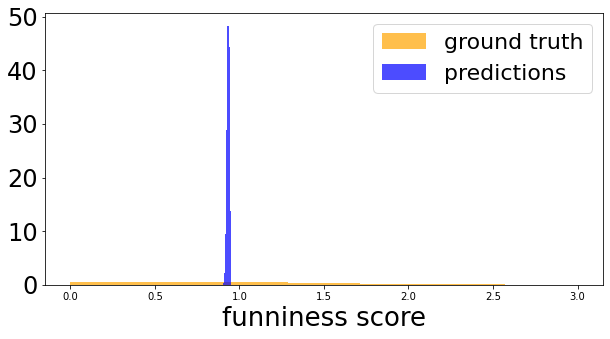

In [ ]:
# === instanciate data loader using edited and/or original sentences ===
CONCAT = False # IMPORTANT: change to False if modifying below datasets
train_set = Task1Dataset(X_edited, y)#, X_original) # best results without both headlines
test = Task1Dataset(X_test_edited, y_test)#, X_test_original) # best results without both headlines

BATCH_SIZE = 64
train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)
test_loader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)
print("Dataloaders created.")

# ==train best model on full train set ===
best_model = CustomTransformerModel(VOCAB_SIZE, EMBEDDING_DIM, N_HEADS, HIDDEN_FF_DIM, N_LAYERS, DROPOUT, CONCAT)
best_model.to(device)

optimizer = torch.optim.Adam(best_model.parameters())
losses = train(train_loader, test_loader, best_model, epochs)

# == test model ==
_, _, pred, y_true = eval(test_loader, best_model)
print("test RMSE: ", float(np.sqrt(np.mean((y_true - pred)**2))))
print("test r2 score: ", r2_score(y_true, pred))
fig = plt.figure(figsize=(10, 5))
plt.hist(y_test, color='orange', alpha=0.7, bins=7, label="ground truth", density=True)
plt.hist(pred, color='b', alpha=0.7, bins=7, label="predictions", density=True)
plt.yticks(fontsize=24)
plt.xlabel('funniness score', fontsize=26)
plt.legend(fontsize=22)
plt.show()